In [4]:
import time
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.stats.multitest

In [5]:
data = pd.read_csv('../../data/data.csv')
dataset_names = data.columns[2:].tolist()
data

,system,system_alias,101,102,103,104,105,106,107,108,...,134,136,137,139,140,143,144,145,146,149
0,mdt5,s0,0.6217,0.5382,0.6383,0.7714,0.5588,0.7420,0.5589,0.6113,...,0.7989,0.5630,0.6222,0.8070,0.5318,0.7150,0.4955,0.5840,0.6160,0.6316
1,baselineBM25,s3,0.3870,0.5011,0.6144,0.7188,0.2805,0.7498,0.6984,0.6396,...,0.6667,0.4973,0.5897,0.7362,0.3627,0.5703,0.5406,0.4754,0.6381,0.5272
2,WatSMC-CALQAHC2,s1,0.5856,0.6832,0.5557,0.6510,0.5601,0.3493,0.6309,0.6427,...,0.6927,0.3907,0.6714,0.6647,0.5210,0.4590,0.7100,0.3828,0.6548,0.4430
3,WatSMC-Correct,s4,0.3360,0.4091,0.5310,0.4094,0.5262,0.6678,0.6794,0.6073,...,0.7058,0.4646,0.6104,0.6269,0.4348,0.4927,0.6697,0.6521,0.6432,0.4322
4,WatSAE-BM25,s2,0.1714,0.3116,0.3213,0.2517,0.2490,0.1076,0.2112,0.2242,...,0.1814,0.1925,0.1480,0.1695,0.2902,0.2760,0.3423,0.1241,0.2754,0.2415


In [6]:
# Utility functions

def get_weights(sota_index, baseline_index, k):
    """
    Get weights for the weighted random dataset selection.
    k is the bias variable.
    If baseline_index is -1, then the average is used.
    """
    weights = []
    for dataset_name in dataset_names:
        if baseline_index == -1:
            difference = data.loc[sota_index, dataset_name] - data[data.index != sota_index][dataset_name].max()
        else:
            difference = data.loc[sota_index, dataset_name] - data.loc[baseline_index, dataset_name]
        weights.append(1 / (1 + np.exp(-k * difference)))
    return weights


def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    e = np.exp(x)
    return e / np.sum(e)

In [7]:
# Multiple comparison w/ control
num_repetition = 1000
num_selected_datasets = 15
methods = ['Uncorrected', 'Bonferroni', 'Holm', 'Hommel', 'Simes-Hochberg']
reject_dict = {method: [] for method in methods}
reject_sota_dict = {method: [] for method in methods}
p_value_dict = {method: [] for method in methods}
sota_index = 0
baseline_index = 2

for k in range(21):
    start_time = time.time()
    reject_counter_dict = {method: 0 for method in methods}
    reject_sota_counter_dict = {method: 0 for method in methods}
    p_value_acc_dict = {method: [] for method in methods}
    for i in range(num_repetition):
        weights = get_weights(sota_index, -1, k)
        selected_datasets = np.random.choice(dataset_names, num_selected_datasets, replace=False, p=softmax(weights))

        data_partial = data[selected_datasets]
        p_values_uncorrected = [stats.ttest_rel(data_partial.iloc[0, 2:].values, data_partial.iloc[j, 2:].values).pvalue for j in range(1, data.shape[0])]
        for method in methods[1:]:
            post_hoc = statsmodels.stats.multitest.multipletests(p_values_uncorrected, alpha=0.05, method=method.lower())
            rejects = post_hoc[0]
            reject_counter_dict[method] += int(rejects[baseline_index - 1])
            reject_sota_counter_dict[method] += int(rejects.all())
            p_value_acc_dict[method].append(post_hoc[1][baseline_index - 1])

        reject_counter_dict['Uncorrected'] += int(p_values_uncorrected[baseline_index - 1] < 0.05)
        reject_sota_counter_dict['Uncorrected'] += int((np.array(p_values_uncorrected) <= 0.05).all())
        p_value_acc_dict['Uncorrected'].append(p_values_uncorrected[baseline_index - 1])

    for method in methods:
        reject_dict[method].append(reject_counter_dict[method])
        reject_sota_dict[method].append(reject_sota_counter_dict[method])
        p_value_dict[method].append(p_value_acc_dict[method])

    print(f'k = {k}, time spent: {round(time.time() - start_time, 2)}s')

k = 0, time spent: 67.11s
k = 1, time spent: 59.54s
k = 2, time spent: 60.35s
k = 3, time spent: 56.25s
k = 4, time spent: 56.91s
k = 5, time spent: 59.0s
k = 6, time spent: 56.88s
k = 7, time spent: 56.86s
k = 8, time spent: 57.02s
k = 9, time spent: 56.59s
k = 10, time spent: 56.82s
k = 11, time spent: 61.02s
k = 12, time spent: 69.98s
k = 13, time spent: 57.44s
k = 14, time spent: 57.19s
k = 15, time spent: 58.08s
k = 16, time spent: 66.25s
k = 17, time spent: 61.03s
k = 18, time spent: 61.16s
k = 19, time spent: 61.94s
k = 20, time spent: 58.86s


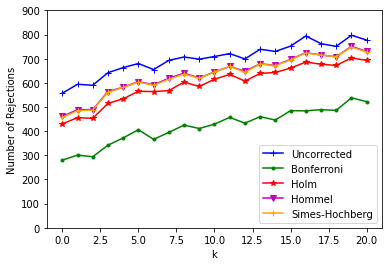

In [14]:
# Plot rejected times (SOTA v.s. one baseline)
markers = itertools.cycle(('+', '.', '*', 'v'))
colors = itertools.cycle(('blue', 'green', 'red', 'm', 'orange'))
for method in methods:
    plt.plot(np.arange(0, 21), reject_dict[method], label=method, marker=next(markers), color=next(colors))
plt.legend()
plt.ylabel('Number of Rejections')
plt.xlabel('k')
plt.ylim((0, 900))
plt.savefig('pair-rejection.pdf')

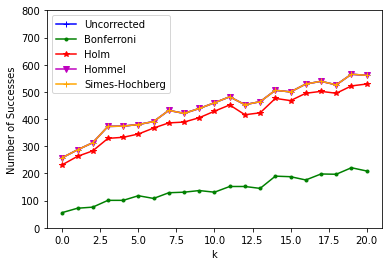

In [15]:
# Plot rejected times (SOTA v.s. all baselines)
markers = itertools.cycle(('+', '.', '*', 'v'))
colors = itertools.cycle(('blue', 'green', 'red', 'm', 'orange'))
for method in methods:
    plt.plot(np.arange(0, 21), reject_sota_dict[method], label=method, marker=next(markers), color=next(colors))
plt.legend()
plt.ylabel('Number of Successes')
plt.xlabel('k')
plt.ylim((0, 800))
plt.savefig('all-rejection.pdf')

In [11]:
for method in methods:
    print(f'{method}: {reject_sota_dict[method]}')

Uncorrected: [258, 287, 313, 373, 374, 380, 391, 432, 421, 439, 460, 482, 453, 464, 506, 500, 529, 539, 526, 565, 561]
Bonferroni: [56, 72, 76, 101, 101, 118, 108, 129, 131, 137, 131, 152, 152, 145, 190, 188, 176, 198, 197, 221, 209]
Holm: [232, 263, 283, 329, 333, 345, 367, 386, 389, 405, 429, 452, 416, 423, 476, 468, 495, 502, 495, 522, 529]
Hommel: [258, 287, 313, 373, 374, 380, 391, 432, 421, 439, 460, 482, 453, 464, 506, 500, 529, 539, 526, 565, 561]
Simes-Hochberg: [258, 287, 313, 373, 374, 380, 391, 432, 421, 439, 460, 482, 453, 464, 506, 500, 529, 539, 526, 565, 561]


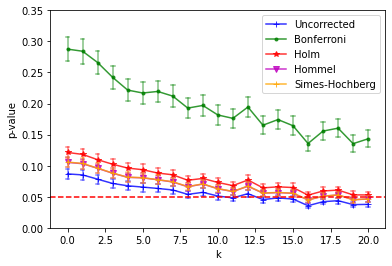

In [16]:
# Plot p-values (SOTA v.s. one baseline)
# Confidence Interval: https://rowannicholls.github.io/python/statistics/confidence_intervals.html
C = 0.95
horizontal_line_width = 0.25
markers = itertools.cycle(('+', '.', '*', 'v'))
colors = itertools.cycle(('blue', 'green', 'red', 'm', 'orange'))
for j, method in enumerate(methods):
    values = p_value_dict[method]
    color = next(colors)
    marker = next(markers)
    for i, x in enumerate(values):
        # Descriptive statistics
        n = len(x)  # Sample size
        x_bar = np.mean(x)  # Mean
        s = np.std(x, ddof=1)  # Sample standard deviation

        # Calculate confidence interval
        df = n - 1
        alpha = (1 - C) / 2
        t_star = stats.t.ppf(alpha, df)
        ci_lower = x_bar + t_star * s / np.sqrt(n)
        ci_upper = x_bar - t_star * s / np.sqrt(n)

        left = i - horizontal_line_width / 2
        right = i + horizontal_line_width / 2

        plt.plot([i, i], [ci_upper, ci_lower], color=color, alpha=0.5)
        plt.plot([left, right], [ci_upper, ci_upper], color=color, alpha=0.5)
        plt.plot([left, right], [ci_lower, ci_lower], color=color, alpha=0.5)

    plt.plot(np.arange(0, 21), np.mean(p_value_dict[method], axis=1), label=methods[j], marker=marker, color=color, alpha=0.8)

plt.legend()
plt.axhline(y=0.05, color='r', linestyle='--')
plt.ylabel('p-value')
plt.xlabel('k')
plt.ylim((0.0, 0.35))
plt.savefig('pair-p-value.pdf')